In [2]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.impute import SimpleImputer  # Sửa lỗi import SimpleImputer
from sklearn.preprocessing import Normalizer, scale
from sklearn.metrics import (mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error, 
                             accuracy_score, precision_score, recall_score, f1_score)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.utils import model_to_dot, to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Embedding, Input, dot, concatenate, 
                                     Conv2D, MaxPooling2D, BatchNormalization, Reshape)
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint

# Cấu hình Matplotlib và Seaborn
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style='whitegrid', color_codes=True)

# Nếu chạy trong Jupyter Notebook
%matplotlib inline  


Reading Data and the pre analysis:

In [3]:
rates = pd.read_csv('dataset/ratings.csv')
# we do not care when the user rated the particular movie!
rates.drop(['timestamp'], axis=1, inplace=True)
print('table of rates : (rows, features): ',rates.shape)
movies = pd.read_csv('dataset/movies.csv')
print('table of movies : (rows, features): ',movies.shape)
rates.head()
     

table of rates : (rows, features):  (100836, 3)
table of movies : (rows, features):  (9742, 3)


userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

In [4]:
movies.head()


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [5]:
users = rates.userId.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
Movies = rates.movieId.unique()
movie_map = {i:val for i,val in enumerate(Movies)}
inverse_movie_map = {val:i for i,val in enumerate(Movies)}

print("We have %d users"%users.shape[0])
print("We have %d movies"%Movies.shape[0])

We have 610 users
We have 9724 movies


In [6]:

rates.describe()

userId        movieId         rating
count  100836.000000  100836.000000  100836.000000
mean      326.127564   19435.295718       3.501557
std       182.618491   35530.987199       1.042529
min         1.000000       1.000000       0.500000
25%       177.000000    1199.000000       3.000000
50%       325.000000    2991.000000       3.500000
75%       477.000000    8122.000000       4.000000
max       610.000000  193609.000000       5.000000

In [7]:
ratings_df = rates.groupby(['userId', 'movieId']).agg("max")
print(len(ratings_df))
if (len(ratings_df) == rates.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")

100836
there are no such cases where the user has rated the same movie twice.


<Axes: xlabel='rating'>

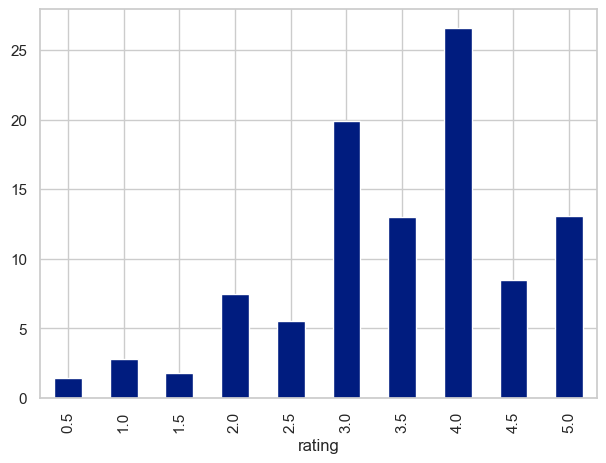

In [8]:
count_rates = rates.groupby('rating').count()
count_rates['perc_total']=round(count_rates['userId']*100/count_rates['userId'].sum(),1)
count_rates['perc_total'].plot.bar()

In [9]:
ratedmovies = pd.merge(rates, movies, on = 'movieId')
ratedmovies.tail()

userId  movieId  rating                           title  \
100831     610   166534     4.0                    Split (2017)   
100832     610   168248     5.0   John Wick: Chapter Two (2017)   
100833     610   168250     5.0                  Get Out (2017)   
100834     610   168252     5.0                    Logan (2017)   
100835     610   170875     3.0  The Fate of the Furious (2017)   

                             genres  
100831        Drama|Horror|Thriller  
100832        Action|Crime|Thriller  
100833                       Horror  
100834                Action|Sci-Fi  
100835  Action|Crime|Drama|Thriller

Genres Distribution:


In [10]:
# Create a function to find genres in the dataset
genres = {}
def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word] = genres.get(word, 0) + 1
            
find_genres()
genres['None'] = genres.pop('(no genres listed)')
listofgenres = list(genres.keys())
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 'None': 34}

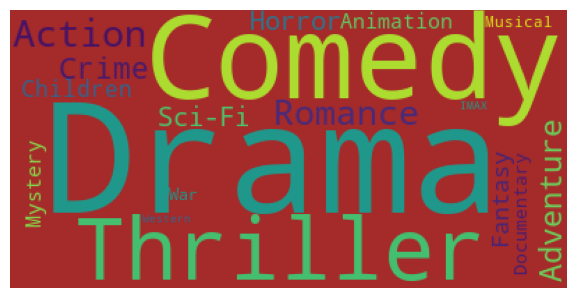

In [11]:
wordcloud = WordCloud(width=400, height=200, background_color = 'brown', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Movies table with genres in one hot format


In [12]:

# GENRES = movies['genres']
MoviesWithGenres = movies.copy()
for genre in listofgenres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
MoviesWithGenres.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  Adventure  Animation  \
0  Adventure|Animation|Children|Comedy|Fantasy          1          1   
1                   Adventure|Children|Fantasy          1          0   
2                               Comedy|Romance          0          0   
3                         Comedy|Drama|Romance          0          0   
4                                       Comedy          0          0   

   Children  Comedy  Fantasy  Romance  Drama  ...  Horror  Mystery  Sci-Fi  \
0         1       1        1        0      0  ...       0        0       0   
1         1       0        1        0      0  ...       0        0       0   
2         0       1        0        1      0  ...       0        0       0   
3         0       1        0        1      1  ...       0        0       0   
4         0       1        0        0      0  ...       0        0       0   

   War  Musical  Documentary  IMAX  Western  Film-Noir  None  
0    0        0            0     0        0          0     0  
1    0        0            0     0        0          0     0  
2    0        0            0     0        0          0     0  
3    0        0            0     0        0          0     0  
4    0        0            0     0        0          0     0  

[5 rows x 23 columns]

List of top scored movies over the whole range of movies, Using Weighted_Score


In [13]:
avg_movie_rating = pd.DataFrame(rates.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index
avg_rating_all= rates['rating'].mean()
min_reviews=20
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.index.name = None

def weighted_rating(x, m=min_reviews, C=avg_rating_all):
  v = x['count']
  R = x['mean']
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)


movie_score = movie_score.copy()
movie_score.loc[:, 'weighted_score'] = movie_score.apply(weighted_rating, axis=1)
# movie_score.head()
movie_score = pd.merge(movie_score,MoviesWithGenres,on='movieId')
# movie_score.head()
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])
     

title  count      mean  \
101                    Shawshank Redemption, The (1994)    317  4.429022   
223                               Godfather, The (1972)    192  4.289062   
652                                   Fight Club (1999)    218  4.272936   
81            Star Wars: Episode IV - A New Hope (1977)    251  4.231076   
25                           Usual Suspects, The (1995)    204  4.237745   
159                             Schindler's List (1993)    220  4.225000   
313                      Godfather: Part II, The (1974)    129  4.259690   
94                                  Pulp Fiction (1994)    307  4.197068   
295   Star Wars: Episode V - The Empire Strikes Back...    211  4.215640   
1088                            Dark Knight, The (2008)    149  4.238255   

      weighted_score                       genres  
101         4.373980                  Crime|Drama  
223         4.214770                  Crime|Drama  
652         4.208114  Action|Crime|Drama|Thriller  
81          4.177237      Action|Adventure|Sci-Fi  
25          4.172014       Crime|Mystery|Thriller  
159         4.164713                    Drama|War  
313         4.157927                  Crime|Drama  
94          4.154529  Comedy|Crime|Drama|Thriller  
295         4.153814      Action|Adventure|Sci-Fi  
1088        4.151072      Action|Crime|Drama|IMAX

Getting top n movies per genre:


In [14]:
def best_by_genre(genre,top_n):
  return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

best_by_genre('Drama',5)  

title  count      mean  weighted_score
101  Shawshank Redemption, The (1994)    317  4.429022        4.373980
223             Godfather, The (1972)    192  4.289062        4.214770
652                 Fight Club (1999)    218  4.272936        4.208114
159           Schindler's List (1993)    220  4.225000        4.164713
313    Godfather: Part II, The (1974)    129  4.259690        4.157927

Heavily Rated Movies


In [15]:
df_n_ratings = pd.DataFrame(ratedmovies.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(ratedmovies.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

mean ratings  total ratings
title                                                                 
Forrest Gump (1994)                            4.164134            329
Shawshank Redemption, The (1994)               4.429022            317
Pulp Fiction (1994)                            4.197068            307
Silence of the Lambs, The (1991)               4.161290            279
Matrix, The (1999)                             4.192446            278
Star Wars: Episode IV - A New Hope (1977)      4.231076            251
Jurassic Park (1993)                           3.750000            238
Braveheart (1995)                              4.031646            237
Terminator 2: Judgment Day (1991)              3.970982            224
Schindler's List (1993)                        4.225000            220

/var/folders/vz/38l0trnx7q574vg2l46q0f980000gn/T/ipykernel_17402/266369279.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_n_ratings['total ratings'], bins=20)


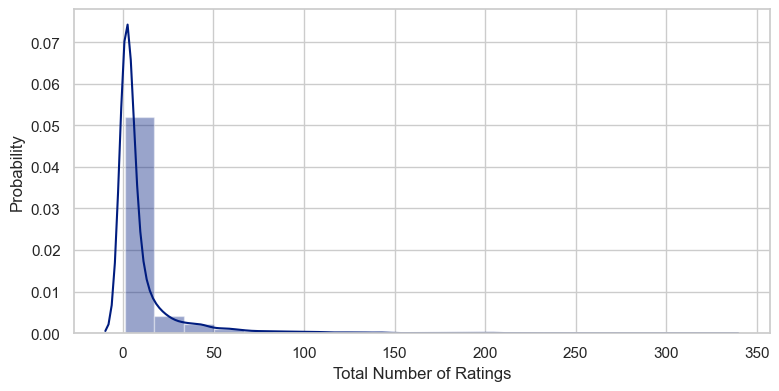

In [16]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

/var/folders/vz/38l0trnx7q574vg2l46q0f980000gn/T/ipykernel_17402/429613275.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(best_by_genre('Drama',200)['count'], bins=30)


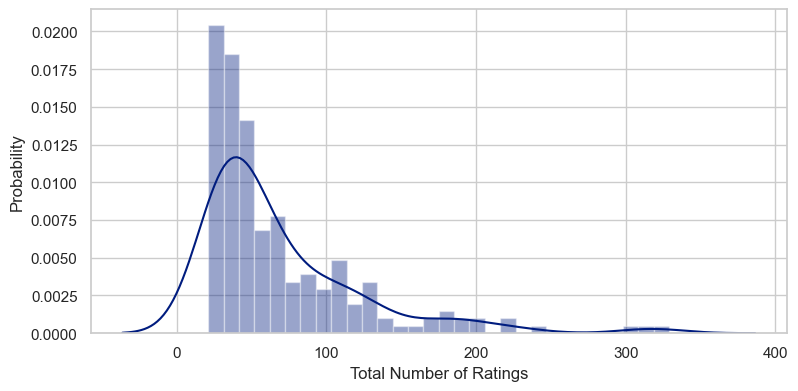

In [17]:
plt.figure(figsize=(8,4))
sns.distplot(best_by_genre('Drama',200)['count'], bins=30)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

Mean ratings vs Total number of ratings


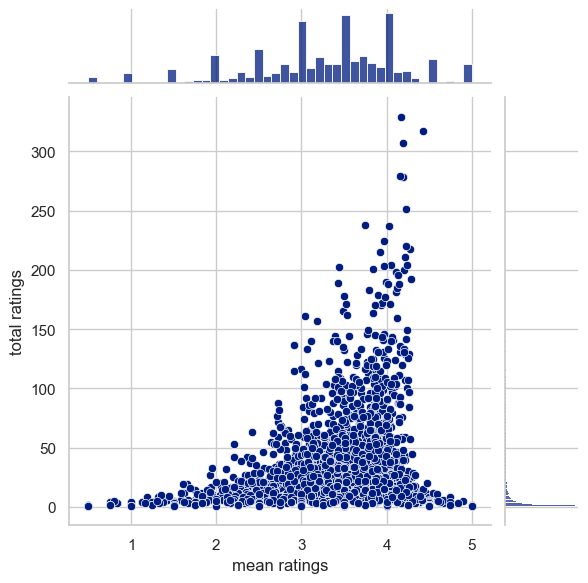

In [18]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

Collaborative Filtering (CF) Recommendation Model - Memory-based

Item-based Collaborative Filtering

In [19]:
ratings_df = pd.pivot_table(rates, index='userId', columns='movieId', aggfunc="max")
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    NaN    4.0    NaN    NaN    4.0    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 193565 193567 193571 193573 193579 193581 193583 193585 193587   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 193609  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 9724 columns]

In [20]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
  #get all users who watched a specific movie
  df_movie_users_series = ratedmovies.loc[ratedmovies['title']==movie_name]['userId']
  df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
  other_movies = pd.merge(df_movie_users,ratedmovies,on='userId')
  other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
  other_users_watched['perc_who_watched'] = round(other_users_watched['userId'] * 100 / other_users_watched['userId'].iloc[0], 1)
  return other_users_watched[:10]

In [21]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Waiting to Exhale (1995)')

userId  perc_who_watched
title                                                     
Shawshank Redemption, The (1994)       7             100.0
Waiting to Exhale (1995)               7             100.0
Pulp Fiction (1994)                    7             100.0
Silence of the Lambs, The (1991)       6              85.7
Philadelphia (1993)                    6              85.7
Sleepless in Seattle (1993)            6              85.7
While You Were Sleeping (1995)         6              85.7
Apollo 13 (1995)                       6              85.7
Sabrina (1995)                         6              85.7
Batman (1989)                          6              85.7

In [22]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print('Number of movies which has more than 10 rates: ',len(movie_plus_10_ratings))
movie_plus_10_ratings.index.name = None
filtered_ratings = pd.merge(movie_plus_10_ratings, rates, on="movieId")
print('the number of records in new rates table: ',len(filtered_ratings))
filtered_ratings.head()

Number of movies which has more than 10 rates:  2269
the number of records in new rates table:  81116


mean  count  movieId  userId  rating
0  3.92093    215        1       1     4.0
1  3.92093    215        1       5     4.0
2  3.92093    215        1       7     4.5
3  3.92093    215        1      15     2.5
4  3.92093    215        1      17     4.5

In [23]:
movie_wide = filtered_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_wide.head()
     

userId   1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
movieId                                                    ...                  
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  0.0  0.0  0.0  ...  4.0  0.0  4.0   
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  4.0  0.0  0.0  ...  0.0  4.0  0.0   
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6        4.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  3.0  4.0   

userId   604  605  606  607  608  609  610  
movieId                                     
1        3.0  4.0  2.5  4.0  2.5  3.0  5.0  
2        5.0  3.5  0.0  0.0  2.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  2.0  0.0  0.0  
5        3.0  0.0  0.0  0.0  0.0  0.0  0.0  
6        3.0  0.0  0.0  0.0  0.0  0.0  5.0  

[5 rows x 610 columns]

In [24]:
 
from sklearn.neighbors import NearestNeighbors

movie_matrix = movie_wide.values  # Chuyển DataFrame thành NumPy array



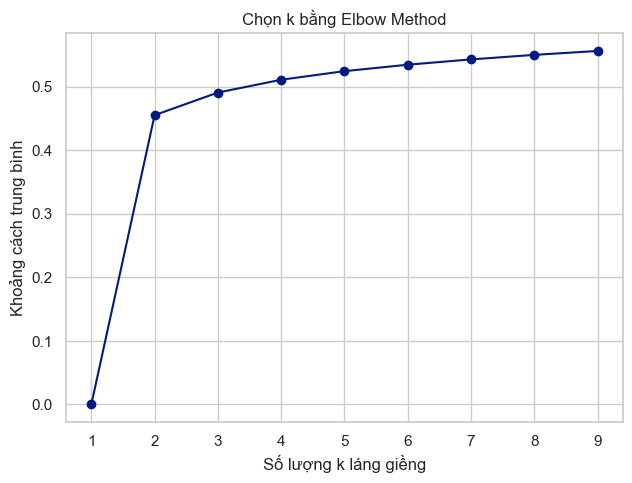

In [25]:
# Tìm k bằng Elbow Method
ks = list(range(1, 10))  # Thử từ k=1 đến k=20
avg_distances = []

for k in ks:
    knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn.fit(movie_matrix)
    distances, _ = knn.kneighbors(movie_matrix)
    avg_distances.append(np.mean(distances[:, -1]))  # Khoảng cách trung bình của láng giềng xa nhất

# Vẽ đồ thị chọn k
plt.plot(ks, avg_distances, marker='o')
plt.xlabel("Số lượng k láng giềng")
plt.ylabel("Khoảng cách trung bình")
plt.title("Chọn k bằng Elbow Method")
plt.show()

In [26]:
model_knn = NearestNeighbors(n_neighbors=2, metric='cosine', algorithm='brute')
model_knn.fit(movie_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=2)

In [27]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(movieid) :
  query_index_movie_ratings = movie_wide.loc[movieid,:].values.reshape(1,-1)
  distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
  for i in range(0,len(distances.flatten())):
    get_movie = movies.loc[movies['movieId']==movieid]['title']
    if i==0:
      print('Recommendations for {0}:\n'.format(get_movie))
    else :
      indices_flat = indices.flatten()[i]
      get_movie = movies.loc[movies['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
      print('{0}: {1}:'.format(i,get_movie))

In [28]:
print_similar_movies(50)


Recommendations for 46    Usual Suspects, The (1995)
Name: title, dtype: object:

1: 257    Pulp Fiction (1994)
Name: title, dtype: object:
2: 277    Shawshank Redemption, The (1994)
Name: title, dtype: object:
3: 828    Reservoir Dogs (1992)
Name: title, dtype: object:
4: 914    Goodfellas (1990)
Name: title, dtype: object:
5: 43    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object:
6: 510    Silence of the Lambs, The (1991)
Name: title, dtype: object:
7: 659    Godfather, The (1972)
Name: title, dtype: object:
8: 520    Fargo (1996)
Name: title, dtype: object:
9: 314    Forrest Gump (1994)
Name: title, dtype: object:
10: 2226    Fight Club (1999)
Name: title, dtype: object:


User-based Collaborative Filtering


In [29]:
user_conf_matrix = ratings_df.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_conf_matrix = user_conf_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_conf_matrix.head(5)

rating                                                              \
movieId    1         2         3         4         5         6         7        
userId                                                                          
1        4.000000  4.366379  4.000000  4.366379  4.366379  4.000000  4.366379   
2        3.948276  3.948276  3.948276  3.948276  3.948276  3.948276  3.948276   
3        2.435897  2.435897  2.435897  2.435897  2.435897  2.435897  2.435897   
4        3.555556  3.555556  3.555556  3.555556  3.555556  3.555556  3.555556   
5        4.000000  3.636364  3.636364  3.636364  3.636364  3.636364  3.636364   

                                       ...                                \
movieId    8         9         10      ...    193565    193567    193571   
userId                                 ...                                 
1        4.366379  4.366379  4.366379  ...  4.366379  4.366379  4.366379   
2        3.948276  3.948276  3.948276  ...  3.948276  3.948276  3.948276   
3        2.435897  2.435897  2.435897  ...  2.435897  2.435897  2.435897   
4        3.555556  3.555556  3.555556  ...  3.555556  3.555556  3.555556   
5        3.636364  3.636364  3.636364  ...  3.636364  3.636364  3.636364   

                                                                               
movieId    193573    193579    193581    193583    193585    193587    193609  
userId                                                                         
1        4.366379  4.366379  4.366379  4.366379  4.366379  4.366379  4.366379  
2        3.948276  3.948276  3.948276  3.948276  3.948276  3.948276  3.948276  
3        2.435897  2.435897  2.435897  2.435897  2.435897  2.435897  2.435897  
4        3.555556  3.555556  3.555556  3.555556  3.555556  3.555556  3.555556  
5        3.636364  3.636364  3.636364  3.636364  3.636364  3.636364  3.636364  

[5 rows x 9724 columns]

In [30]:
user_corr_mat = user_conf_matrix.T.corr()
corrOfuser1 = user_corr_mat.iloc[0]
corrOfuser1.sort_values(ascending=False, inplace=True)
corrOfuser1.dropna(inplace = True)
top50_corr_users = corrOfuser1[1:51]

mylist = []
for i in range(100):
  if ratedmovies[ (ratedmovies['userId'] == 1) & (ratedmovies['movieId'] == i) ].empty:
    mylist.append(i)
  else:
    pass

print('{}nd Movie : '.format(mylist[3]), movies['title'][ movies['movieId'] == mylist[3] ].values)

top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
  if ratedmovies[ (ratedmovies['userId'] == user) & (ratedmovies['movieId'] == mylist[3]) ]['rating'].sum()  :
    count +=1
    users.append(user)

def predict_rating():
  sum_similarity = 0
  weighted_ratings = 0
  for user in users:
    weighted_ratings += top50_corr_users.loc[user] * ratedmovies[(ratedmovies['userId'] == user) & 
                                                              (ratedmovies['movieId'] == mylist[3])]['rating'].sum()
    sum_similarity += top50_corr_users.loc[user]


  return weighted_ratings / sum_similarity

print('the predicted rate for this movie by user 1 is: ',predict_rating())    
print("----------------------------------------------------------") 

5nd Movie :  ['Father of the Bride Part II (1995)']
the predicted rate for this movie by user 1 is:  2.6541266422236722
----------------------------------------------------------
